## Iterators and Generators


We've seen that in Python, anything which can be iterated over is called an iterable:




In [4]:
bowl = {
    "apple" : 5,
    "banana" : 3,
    "orange" : 7
}

for fruit in bowl:
    print(fruit.upper())

APPLE
BANANA
ORANGE


Surprisingly often, we want to iterate over something that takes a moderately
large amount of storage to store. For example, our map images in the
green-graph example.

Our green-graph example involved making an array of all the maps between London
and Birmingham. This kept them all in memory *at the same time*: first we
downloaded all the maps, then we counted the green pixels in each of them. 

This would NOT work if we used more points. We need to use a **generator**

### Iterators

Consider the basic python `range` function:

In [5]:
range(10)

range(0, 10)

In [6]:
total=0
for x in range(int(1e6)): total+= x

total

499999500000

In python 3, in order to avoid allocating a million integers, `range` actually creates an ITERATOR.

We don't actually need a million integers **at once**, just each
integer **in turn** up to a million.

The iterator is an iterable which is not an list.

So we can for loop over it:

In [7]:
for i in range(3): 
    print(i)

0
1
2


An generator object, like range(3), when we iterate over it, works by defining a `next()` method which
moves the iterator forward:

In [8]:
a=iter(range(3))

In [9]:
a.__next__()

0

In [10]:
a.__next__()

1

In [11]:
a.__next__()

2

At the end, `StopIteration` is raised as an exception:

In [12]:
a.__next__()

StopIteration: 

We can turn an iterator back into a list with the `list` constructor function:

In [13]:
list(range(5))

[0, 1, 2, 3, 4]

In [14]:
total=0
for x in range(int(1e6)): total+= x

print(total)

499999500000


### Defining Our Own Iterable

We can make our own iterators by defining *classes* that implement next() and __iter__() methods: this is the iterator protocol.

For each of the *concepts*, in Python, like sequence, container, iterable, python defines a **protocol**, a set of methods a class must implement, in order to be treated as a member of that concept.

The iterator protocol is the protocol that defines things that support `for x in y:`.

To define an iterator, the methods that must be supported are `next()` and `__iter__()`.

`next()` must update the iterator.

We'll see why we need to define `__iter__` in a moment.

In [15]:
class fib_iterator(object):
    def __init__(self, limit, seed1=1, seed2=1):
        self.limit = limit
        self.previous = seed1
        self.current = seed2
        
    def __iter__(self):
        return self
    
    def __next__(self):
        (self.previous, self.current)=(
                self.current, self.previous+self.current)
        self.limit -=1
        if self.limit<0: raise StopIteration()
        return self.current

In [16]:
x=fib_iterator(5)

In [17]:
next(x)

2

In [18]:
next(x)

3

In [19]:
next(x)

5

In [20]:
next(x)

8

In [21]:
for x in fib_iterator(5):
    print(x)

2
3
5
8
13


In [22]:
sum(fib_iterator(1000))

297924218508143360336882819981631900915673130543819759032778173440536722190488904520034508163846345539055096533885943242814978469042830417586260359446115245634668393210192357419233828310479227982326069668668250

### A shortcut to iterables: the `__iter__` method.




In fact, if, to be iterated over, a class just wants to behave as if it were some other iterable, you can just implement `__iter__` and return `iter(some_other_iterable)`, without implementing `next`.  For example, an image class might want to implement some metadata, but behave just as if it were just a 1-d pixel array when being iterated:




In [23]:
from numpy import array
from matplotlib import pyplot as plt

class MyImage(object):
    def __init__(self, pixels):
        self.pixels=array(pixels,dtype='uint8')
        self.channels=self.pixels.shape[2]
        
    def __iter__(self):
        # return an iterator over the pixels
        # See future NumPy lecture for using reshape
        return iter(self.pixels.reshape(-1,self.channels))
    
    def show(self):
        plt.imshow(self.pixels, interpolation="None")

x=[[[255,255,0],[0,255,0]],[[0,0,255],[255,255,255]]]
image=MyImage(x)

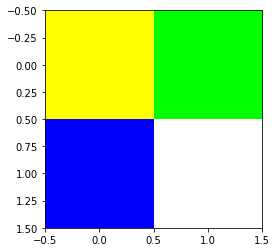

In [24]:
%matplotlib inline
image.show()

In [25]:
x = array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
y = iter(x)
next(y)

array([1, 2, 3, 4])

In [26]:
image.channels

3

In [27]:
from webcolors import rgb_to_name
for pixel in image:
    print(rgb_to_name(pixel))

ModuleNotFoundError: No module named 'webcolors'

The **iterator** protocol is to implement both `__iter__` and
`next`, while the **iterable** protocol is to implement `__iter__` and return
an something iterable.

### Generators

There's a fair amount of "boiler-plate" in the above class-based definition of
an iterable.

Python provides another way to specify something
which meets the iterator protocol: **generators**.

In [28]:
def my_generator():
    yield 5
    yield 10

x=my_generator()

In [29]:
x.__next__()

5

In [30]:
x.__next__()

10

In [31]:
x.__next__()

StopIteration: 

In [32]:
for a in my_generator():
    print(a)

5
10


In [33]:
sum(my_generator())

15

A function which has `yield` statements instead of a `return` statement returns
**temporarily**: it automagically becomes something which implements `next`.

Each call of next() returns control to the function where it
left off.

 Control passes back-and-forth between the generator and the caller.
Our fibonacci example therefore becomes a function rather than a class.

In [34]:
def yield_fibs(limit, seed1=1,seed2=1):
    current=seed1
    previous=seed2
    
    while limit>0:
        limit-=1
        current, previous = current+previous, current
        yield current

In [35]:
sum(yield_fibs(5))

31

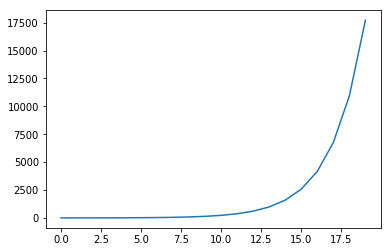

In [36]:
plt.plot(list(yield_fibs(20)))

In [37]:
for a in yield_fibs(10):
    if a%2 == 0:
        print(a)

2
8
34
144


In [38]:
list(yield_fibs(10))

[2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

### Context managers


We saw that instead of separately `open`ing and `close`ing a file, we can have
the file be automatically closed using a context manager:




In [39]:
import yaml

with open('example.yaml') as foo:
    print(yaml.load(foo))

FileNotFoundError: [Errno 2] No such file or directory: 'example.yaml'




How could we define our own one of these, if we too have clean-up code we
always want to run after a calling function has done its work, or set-up code
we want to do first?

We can define a class that meets an appropriate protocol:




In [40]:
class verbose_context():
    def __init__(self, name):
        self.name=name
    def __enter__(self):
        print("Get ready, ", self.name)
    def __exit__(self, exc_type, exc_value, traceback):
        print("OK, done")

with verbose_context("James"):
    print("Doing it!")

Get ready,  James
Doing it!
OK, done




However, this is pretty verbose! Again, a generator with `yield` makes for an easier syntax:




In [13]:
from contextlib import contextmanager

@contextmanager
def verbose_context(name):
    print("Get ready for action, ", name)
    yield name.upper()
    print("You did it")

with verbose_context("James") as shouty:
    print("Doing it, ",  shouty)

Get ready for action,  James
Doing it,  JAMES
You did it




Again, we use `yield` to temporarily return from a function.


### Decorators


When doing functional programming, we may often want to define mutator
functions which take in one function and return a new function, such as our
derivative example earlier.




In [42]:
def repeater(count):
    def wrap_function_in_repeat(func):
        
        def _repeated(x):
            counter=count
            while counter>0:
                counter-=1
                x=func(x)
            return x
        
        return _repeated
    return wrap_function_in_repeat

from math import sqrt

fiftytimes=repeater(50)

fiftyroots=fiftytimes(sqrt)

print(fiftyroots(100))

1.000000000000004


It turns out that, quite often, we want to apply one of these to a function as we're defining a class.
For example, we may want to specify that after certain methods are called, data should always be stored:

Any function which accepts a function as its first argument and returns a function can be used as a **decorator** like this.

Much of Python's standard functionality is implemented as decorators: we've
seen @contextmanager, @classmethod and @attribute. The @contextmanager
metafunction, for example, takes in an iterator, and yields a class conforming
to the context manager protocol.


In [43]:
@repeater(3)
def hello(name):
    return "Hello, "+ name

In [44]:
hello("James")

'Hello, Hello, Hello, James'

In [21]:
def metaoperator(a):
    def operation(func):
        return func(a)
    return operation

@metaoperator(6)
def squarer(x):
    return x*x

squarer

36

In [27]:
def adder(x):
    def helper(y):
        return x + y
    return helper

add_5 = adder(5)

13

### Test generators


A few weeks ago we saw a test which loaded its test cases from a YAML file and
asserted each input with each output. This was nice and concise, but had one
flaw: we had just one test, covering all the fixtures, so we got just one . in
the test output when we ran the tests, and if any test failed, the rest were
not run. We can do a nicer job with a test **generator**:





In [45]:
def assert_examplar(**fixture):
    answer=fixture.pop('answer')
    assert_equal(greet(**fixture), answer)

def test_greeter():
    with open(os.path.join(os.path.dirname(
        __file__),'fixtures','samples.yaml')
        ) as fixtures_file:
        fixtures=yaml.load(fixtures_file)
        
        for fixture in fixtures:
            
            yield assert_exemplar(**fixture)

Each time a function beginning with `test_` does a `yield` it results in another test.

### Negative test contexts managers

We have seen this:

In [38]:
from nose.tools import assert_raises

with assert_raises(AttributeError):
    x=2
    x.foo()

We can now see how `nose` might have implemented this:

In [84]:
x = iter("Blah")
next(x)
for i in iter("Blah"):
    print(i)

B
l
a
h


In [85]:
from contextlib import contextmanager

@contextmanager
def reimplement_assert_raises(exception):
    try:
        yield
    except exception:
        pass
    else:
        raise Exception("Expected,", exception, 
                " to be raised, nothing was.")

In [86]:
with reimplement_assert_raises(AttributeError):
    x=2
    x.foo()

### Negative test decorators

Nose also implements a very nice negative test decorator:

In [52]:
import inspect
inspect.getmro(ZeroDivisionError)

(ZeroDivisionError, ArithmeticError, Exception, BaseException, object)

In [93]:
from nose.tools import raises

@raises(TypeError, ValueError)
def test_raises_type_error():
    raise TypeError("This test passes")
    #raise ValueError("This test passes")
    #raise ZeroDivisionError("This test fails")

In [94]:
test_raises_type_error()

In [95]:
@raises(Exception)
def test_that_fails_by_passing():
    pass

In [96]:
test_that_fails_by_passing()

AssertionError: test_that_fails_by_passing() did not raise Exception

We could reimplement this ourselves now too:

In [149]:
def homemade_raises_decorator(exception):
    def wrap_function(func): #Closure over exception
        # Define a function which runs another function under the assert_raises context:
        def _output(*args): #Closure over func and exception
            with assert_raises(exception):
                func(*args)
        # Return it
        return _output
    return wrap_function

In [150]:
@homemade_raises_decorator(TypeError)
def test_raises_type_error():
    raise TypeError("This test passes")

In [151]:
test_raises_type_error()